# Assignment 3

In [26]:
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import chi2_contingency
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
from scipy.cluster.hierarchy import linkage
from statsmodels.stats.multitest import multipletests
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation



## Part 1

In [19]:
# Load the TSV file
file_path = 'ERP009868.tsv'
expression_data = pd.read_csv(file_path, sep='\t', index_col=0)

# Load the metadata
metadata_path = 'metadata_ERP009868.tsv'
metadata = pd.read_csv(metadata_path, sep='\t')

# Part 2

Running Gaussian Mixture Models...


C:\Users\adams\AppData\Local\Temp\ipykernel_17688\173699734.py:25: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



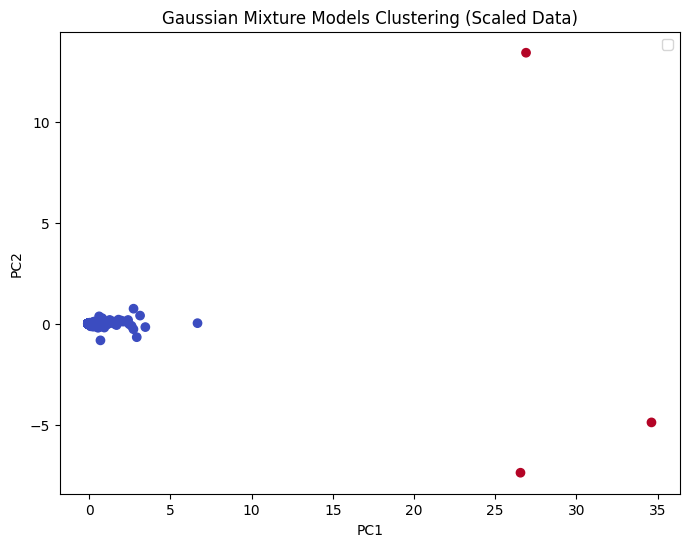

In [20]:
# Part A)
# Subset to the 5,000 most variable genes
var_genes = expression_data.std(axis=1).sort_values(ascending=False).head(5000).index
expression_subset = expression_data.loc[var_genes]

# Run Gaussian Mixture Models
print("Running Gaussian Mixture Models...")
scaler = MinMaxScaler()
expression_scaled = scaler.fit_transform(expression_subset)

gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(expression_scaled)
gmm_labels = gmm.predict(expression_scaled)

# Part B)
# Visualize the clustering results
pca = PCA(n_components=2)
X_pca = pca.fit_transform(expression_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='coolwarm')
plt.title("Gaussian Mixture Models Clustering (Scaled Data)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

Running Gaussian Mixture Models with 3, 4, and 5 clusters...


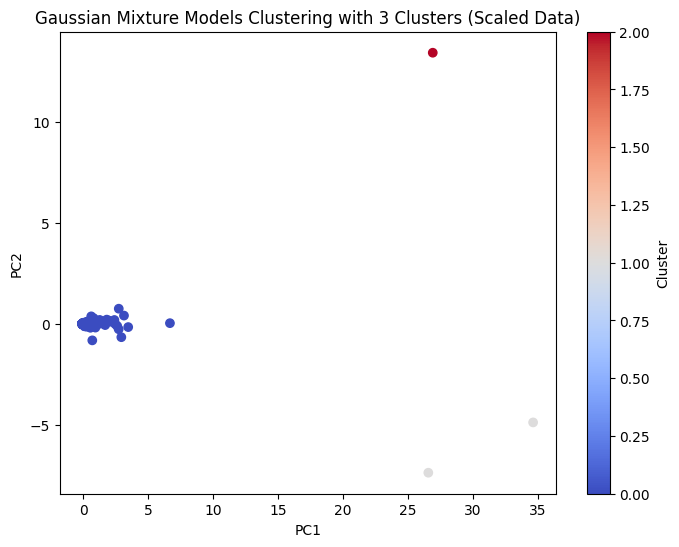

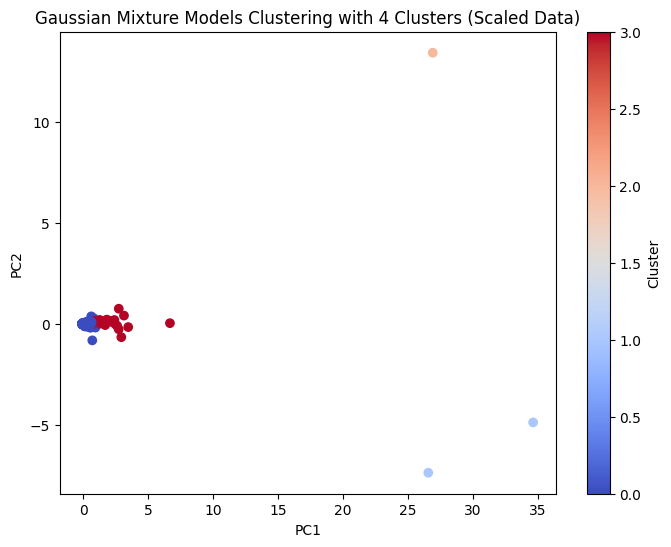

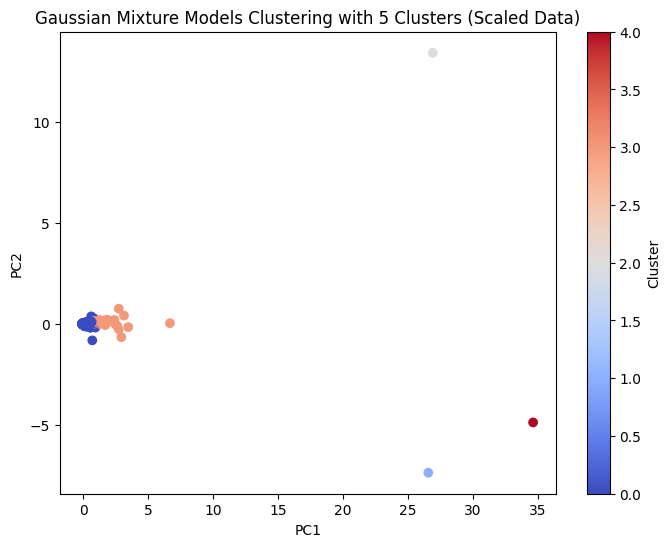

In [21]:
# Part D)
# Choose 3, 4, and 5 clusters
# Run Gaussian Mixture Models
print("Running Gaussian Mixture Models with 3, 4, and 5 clusters...")

# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
expression_scaled = scaler.fit_transform(expression_subset)

# Loop through the different cluster counts
for n_clusters in [3, 4, 5]:
    # Run GMM with the current number of clusters
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(expression_scaled)
    gmm_labels = gmm.predict(expression_scaled)
    
    # Perform PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(expression_scaled)
    
    # Visualize the clustering results
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='coolwarm')
    plt.title(f"Gaussian Mixture Models Clustering with {n_clusters} Clusters (Scaled Data)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.colorbar(label='Cluster')
    plt.show()


In [22]:
def run_gmm_clustering(expression_data, n_genes):
    # Subset to the top n_genes most variable genes
    var_genes = expression_data.std(axis=1).sort_values(ascending=False).head(n_genes).index
    expression_subset = expression_data.loc[var_genes]
    
    # Scale the data
    scaler = StandardScaler()
    expression_scaled = scaler.fit_transform(expression_subset)
    
    # Run Gaussian Mixture Models
    gmm = GaussianMixture(n_components=2, random_state=42)
    gmm.fit(expression_scaled)
    gmm_labels = gmm.predict(expression_scaled)
    
    return gmm_labels

# Run GMM clustering with different numbers of genes
gene_counts = [10, 100, 1000, 10000]
cluster_labels = {}

for n_genes in gene_counts:
    cluster_labels[n_genes] = run_gmm_clustering(expression_data, n_genes)

# Perform chi-squared tests to compare cluster assignments
chi2_results = pd.DataFrame()

for i, n_genes_1 in enumerate(gene_counts):
    for j, n_genes_2 in enumerate(gene_counts):
        if i < j:
            labels_1 = cluster_labels[n_genes_1]
            labels_2 = cluster_labels[n_genes_2]
            
            # Ensure the label arrays have the same length
            min_length = min(len(labels_1), len(labels_2))
            labels_1 = labels_1[:min_length]
            labels_2 = labels_2[:min_length]
            
            chi2, p, _, _ = chi2_contingency(pd.crosstab(labels_1, labels_2))
            chi2_results = pd.concat([chi2_results, pd.DataFrame({
                'n_genes_1': n_genes_1,
                'n_genes_2': n_genes_2,
                'chi2_statistic': chi2,
                'p_value': p
            }, index=[0])], ignore_index=True)

print(chi2_results)

# Visualize the changes in cluster memberships using an alluvial diagram
min_length = min(len(cluster_labels[n]) for n in gene_counts)

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(gene_counts),
        color="blue"
    ),
    link=dict(
        source=[0, 0, 0, 1, 1, 2],
        target=[1, 2, 3, 2, 3, 3],
        value=[sum(cluster_labels[10][:min_length] == cluster_labels[100][:min_length]), 
               sum(cluster_labels[10][:min_length] == cluster_labels[1000][:min_length]),
               sum(cluster_labels[10][:min_length] == cluster_labels[10000][:min_length]),
               sum(cluster_labels[100][:min_length] == cluster_labels[1000][:min_length]),
               sum(cluster_labels[100][:min_length] == cluster_labels[10000][:min_length]),
               sum(cluster_labels[1000][:min_length] == cluster_labels[10000][:min_length])]
    )
)])

fig.update_layout(title_text="Alluvial Diagram: Cluster Membership Changes",
                  font_size=10)
fig.show()

   n_genes_1  n_genes_2  chi2_statistic        p_value
0         10        100        5.804989   1.598077e-02
1         10       1000        5.804989   1.598077e-02
2         10      10000        5.804989   1.598077e-02
3        100       1000       68.587995   1.213405e-16
4        100      10000       68.587995   1.213405e-16
5       1000      10000      693.608855  7.336850e-153


## Part 3

c:\Users\adams\miniconda3\envs\penis\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

c:\Users\adams\miniconda3\envs\penis\Lib\site-packages\seaborn\matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

c:\Users\adams\miniconda3\envs\penis\Lib\site-packages\seaborn\matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

C:\Users\adams\AppData\Local\Temp\ipykernel_17688\231109985.py:87: UserWarning:

Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.



<Figure size 1500x1000 with 0 Axes>

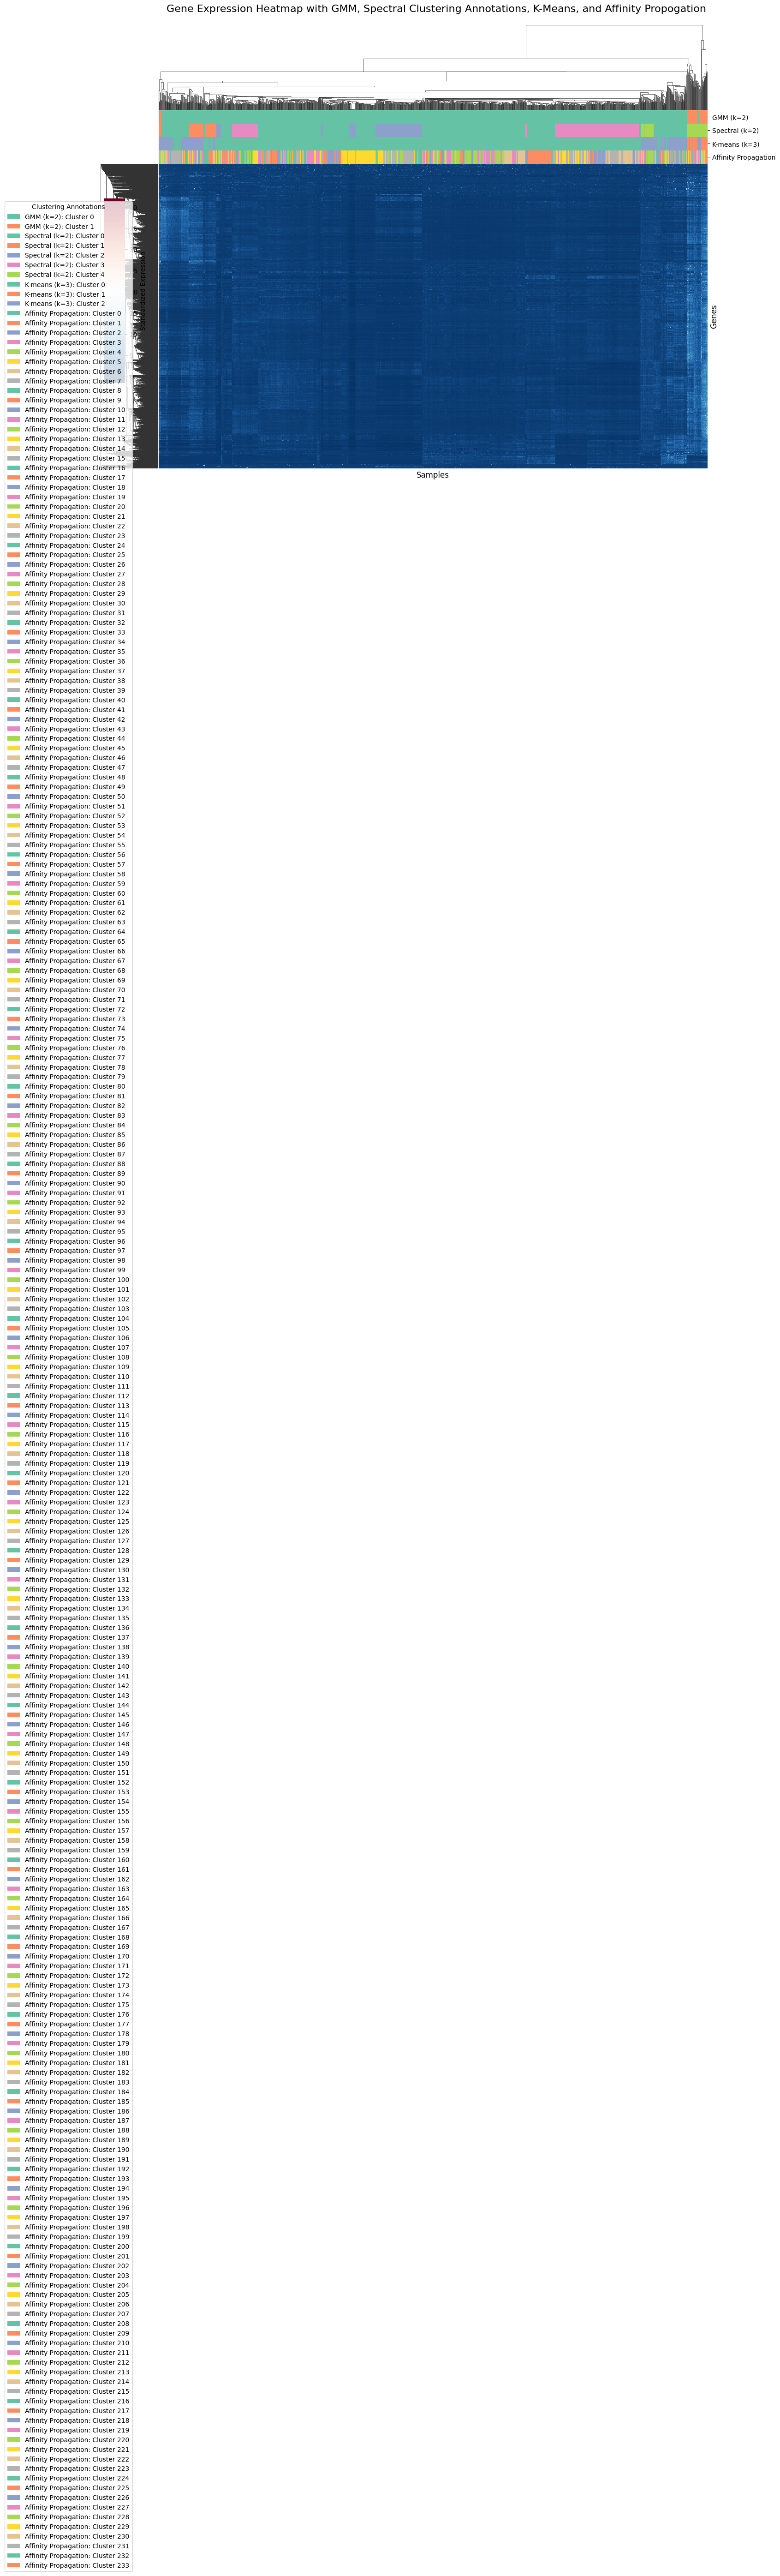

In [28]:
# Get the 5,000 most variable genes
var_genes = expression_data.std(axis=1).sort_values(ascending=False).head(5000).index
expression_subset = expression_data.loc[var_genes]

# Scale the data for better visualization
scaler = StandardScaler()
expression_scaled = pd.DataFrame(
    scaler.fit_transform(expression_subset.T).T,  # Scale the data
    index=expression_subset.index,
    columns=expression_subset.columns
)

# Create annotation DataFrame
annotations = pd.DataFrame(index=expression_subset.columns)

# Add GMM clustering results (2 clusters)
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_labels = gmm.fit_predict(expression_scaled.T)
annotations['GMM (k=2)'] = gmm_labels

# Add Spectral Clustering (5 clusters)
spectral = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', random_state=42)
spectral_labels = spectral.fit_predict(expression_scaled.T)
annotations['Spectral (k=2)'] = spectral_labels

# Add K-means clustering results (e.g., 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust n_clusters as needed
kmeans_labels = kmeans.fit_predict(expression_scaled.T)
annotations['K-means (k=3)'] = kmeans_labels  # Add K-means labels to annotations

# Add Affinity Propagation Clustering (Dimitri's method)
affinity = AffinityPropagation(damping=0.9, random_state=42)  # Adjust preference for fewer clusters
affinity_labels = affinity.fit_predict(expression_scaled.T)
annotations['Affinity Propagation'] = affinity_labels

# Create a color mapping for the clusters
cluster_colors = sns.color_palette("Set2", n_colors=3)  # We can use up to 3 colors
annotation_colors = {}

for column in annotations.columns:
    unique_values = sorted(annotations[column].unique())
    annotation_colors[column] = dict(zip(unique_values, sns.color_palette("Set2", len(unique_values))))

# Create the colors for the annotations (row colors for heatmap)
col_colors = annotations.apply(lambda x: x.map(annotation_colors[x.name]))

# Create the clustermap with both GMM and Spectral clustering results
plt.figure(figsize=(15, 10))
clustermap = sns.clustermap(
    expression_scaled,  # Scaled data
    cmap='RdBu_r',  # Red-Blue color map
    col_colors=col_colors,  # Annotations on top of the columns
    dendrogram_ratio=(.1, .2),  # Adjust size of the dendrograms
    cbar_pos=(0.02, .2, .03, .4),  # Color bar position
    row_cluster=True,  # Cluster rows (genes)
    col_cluster=True,  # Cluster columns (samples)
    xticklabels=False,  # Don't show sample labels on heatmap
    yticklabels=False,  # Don't show gene labels
    figsize=(15, 10)  # Set figure size
)

# Add titles and labels
plt.suptitle('Gene Expression Heatmap with GMM, Spectral Clustering Annotations, K-Means, and Affinity Propogation', y=1.02, size=16)
clustermap.ax_heatmap.set_xlabel('Samples', size=12)
clustermap.ax_heatmap.set_ylabel('Genes', size=12)

# Adjust colorbar label
clustermap.ax_cbar.set_ylabel('Standardized Expression', size=10)

# Create custom legend for annotations
legend_elements = []
for column in annotations.columns:
    unique_values = sorted(annotations[column].unique())
    for value in unique_values:
        legend_elements.append(
            plt.Rectangle((0, 0), 1, 1, 
                          fc=annotation_colors[column][value],
                          label=f'{column}: Cluster {value}')
        )

# Add legend
plt.legend(handles=legend_elements, 
           title='Clustering Annotations',
           bbox_to_anchor=(1.5, 1),
           loc='upper right')

plt.tight_layout()
plt.show()

## Part 4


Contingency Table for GMM k=2:
GMM k=2             0   1
Mutation Status          
mutated           432   5
non-mutated      1384  65

Contingency Table for GMM k=3:
GMM k=3             0   1    2
Mutation Status               
mutated           431   2    4
non-mutated      1096  53  300

Chi-squared Test Results:
                        Test  Chi-Square Statistic      P-value  Degrees of Freedom  Adjusted P-value (FDR)
GMM (k=2) vs Mutation Status              9.576601 1.970729e-03                   1            1.970729e-03
GMM (k=3) vs Mutation Status            115.269756 9.321602e-26                   2            1.864320e-25


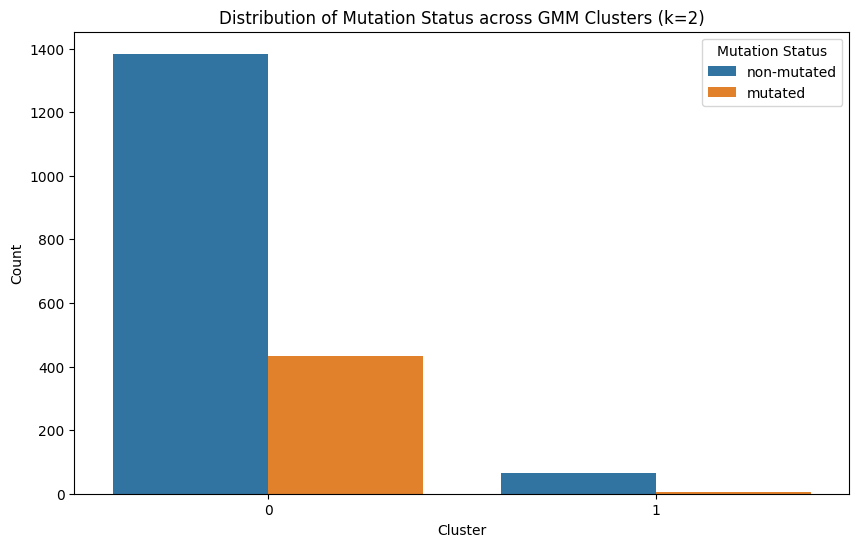

In [24]:


# Create mutation status mapping based on sample IDs
# Assuming the same pattern from Assignment 1 where certain samples are mutated
def create_mutation_status(sample_ids):
    mutation_status = []
    for sample in sample_ids:
        if isinstance(sample, str) and sample.startswith("ERR"):
            # Extract just the numeric part, removing any empty strings
            try:
                # Remove any non-numeric characters after ERR
                numeric_part = ''.join(filter(str.isdigit, sample[3:]))
                if numeric_part and int(numeric_part) < 1046070:
                    mutation_status.append("mutated")
                else:
                    mutation_status.append("non-mutated")
            except ValueError:
                mutation_status.append("non-mutated")
        else:
            mutation_status.append("non-mutated")
    return mutation_status

# Get the clustering results
def perform_chi_squared_tests(expression_data, n_clusters_list=[2, 3]):
    results = []
    
    # Get mutation status for samples
    mutation_status = create_mutation_status(expression_data.columns)
    
    # For each number of clusters
    for n_clusters in n_clusters_list:
        # Perform GMM clustering
        gmm = GaussianMixture(n_components=n_clusters, random_state=42)
        
        # Get the 5,000 most variable genes
        var_genes = expression_data.std(axis=1).sort_values(ascending=False).head(5000).index
        expression_subset = expression_data.loc[var_genes]
        
        # Scale the data
        scaler = StandardScaler()
        expression_scaled = scaler.fit_transform(expression_subset.T)
        
        # Get cluster assignments
        cluster_labels = gmm.fit_predict(expression_scaled)
        
        # Create contingency table
        contingency_table = pd.crosstab(
            pd.Series(mutation_status, name='Mutation Status'),
            pd.Series(cluster_labels, name=f'GMM k={n_clusters}')
        )
        
        # Perform chi-squared test
        chi2, pval, dof, expected = chi2_contingency(contingency_table)
        
        # Store results
        results.append({
            'Test': f'GMM (k={n_clusters}) vs Mutation Status',
            'Chi-Square Statistic': chi2,
            'P-value': pval,
            'Degrees of Freedom': dof
        })
        
        # Print contingency table for inspection
        print(f"\nContingency Table for GMM k={n_clusters}:")
        print(contingency_table)
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Adjust p-values for multiple testing
    results_df['Adjusted P-value (FDR)'] = multipletests(
        results_df['P-value'], 
        method='fdr_bh'  # Benjamini-Hochberg procedure
    )[1]
    
    return results_df

# Run the analysis
results = perform_chi_squared_tests(expression_data)

# Display results
print("\nChi-squared Test Results:")
print(results.to_string(index=False))

# Create a more detailed visualization of the relationships
plt.figure(figsize=(10, 6))

# For k=2 clustering
gmm2 = GaussianMixture(n_components=2, random_state=42)
var_genes = expression_data.std(axis=1).sort_values(ascending=False).head(5000).index
expression_subset = expression_data.loc[var_genes]
scaler = StandardScaler()
expression_scaled = scaler.fit_transform(expression_subset.T)
cluster_labels_2 = gmm2.fit_predict(expression_scaled)

# Create side-by-side bar plots
mutation_status = pd.Series(create_mutation_status(expression_data.columns))
df_plot = pd.DataFrame({
    'Mutation Status': mutation_status,
    'Cluster': cluster_labels_2
})

sns.countplot(data=df_plot, x='Cluster', hue='Mutation Status')
plt.title('Distribution of Mutation Status across GMM Clusters (k=2)')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()